<a href="https://colab.research.google.com/github/derek-pyne/ml_playground/blob/master/A4_GenerativeModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models with Keras
Author: Derek Pyne

Our task is to build a GAN that produces new faces of Simpsons characters.

We will build our work of the Tensorflow implementation down by Greg Surma [here](https://towardsdatascience.com/image-generator-drawing-cartoons-with-generative-adversarial-networks-45e814ca9b6b).

In [0]:
import os
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout, UpSampling2D
from keras.initializers import TruncatedNormal
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar

%matplotlib inline

In [0]:
# Hyperparameters
IMAGE_SIZE = 64
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 50
BETA1 = 0.5
EPSILON = 0.00005
WEIGHT_INIT_STDDEV = 0.02
SAMPLES_TO_SHOW = 5
NOISE_PROP = .05

## 1) Loading dataset
To get our dataset into our Colab Notebook we can mount my Google Drive with the zipped files. 

We can then extract these files, reshape the images, and remove images that do not contain faces with the list provided by the author.

In [0]:
from google.colab import drive
from pathlib import Path
import zipfile

drive.mount('/content/drive')


ZIP_DATA_DIR = Path(r'./drive/My Drive/Datasets/cropped.zip')
INPUT_DATA_DIR = Path(r'./simpsons_faces')
OUTPUT_DIR = Path('./tensorflow/tensorflow{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now()))

zip = zipfile.ZipFile(ZIP_DATA_DIR)
zip.extractall(INPUT_DATA_DIR)
zip.close()

image_blacklist = [
    "9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
    "9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
    "7958""7761","7762","9510","9307","4848","4791","4785","4465","2709",
    "7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
    "6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
    "4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
    "2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
    "1702","1281","1272","772","736","737","691","684","314","242","191"
]

input_images = []
image_paths = list(Path('./simpsons_faces').glob('*.png'))
filtered_image_paths = list(filter(lambda path: not any(image in path.name for image in image_blacklist), image_paths))

pb = Progbar(len(filtered_image_paths))
for i, file in enumerate(filtered_image_paths):
    input_images.append(np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))))
    pb.update(i)
    
input_images = np.asarray(input_images)

np.random.shuffle(input_images)

print ("\nInput: " + str(input_images.shape))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
9629/9648 [============================>.] - ETA: 0s
Input: (9648, 64, 64, 3)


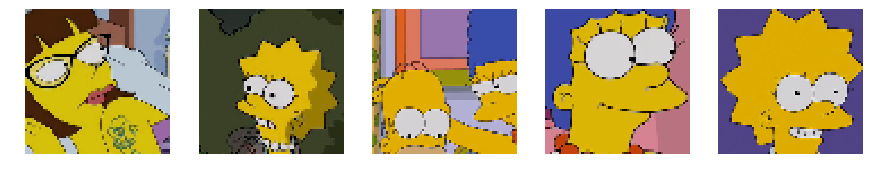

In [0]:
 def show_samples(sample_images):
    figure, axes = plt.subplots(1, len(sample_images), figsize=(15, 15))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
    plt.show()

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images)

## 2) Building our deep model

For our model, we will use a very similar implementation as in Greg's work. The shape of the dense layers is decreased to reflect our smaller image sizes (64x64 compared to 128x128). Five convolution layer are used in discriminator and generator.

In [0]:
def create_generator():
    generator = Sequential()

    generator.add(
        Dense(4 * 4 * 1024, input_dim=NOISE_SIZE, kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    generator.add(Reshape((4, 4, 1024)))
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding='same',
                                  kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    generator.add(BatchNormalization(epsilon=EPSILON))
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same',
                                  kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    generator.add(BatchNormalization(epsilon=EPSILON))
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same',
                                  kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    generator.add(BatchNormalization(epsilon=EPSILON))
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same',
                                  kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    generator.add(BatchNormalization(epsilon=EPSILON))
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh',
                                  kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))

    return generator


def create_discriminator():
    discriminator = Sequential()

    discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding='same',
                             kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV),
                             input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    discriminator.add(BatchNormalization(epsilon=EPSILON))
    discriminator.add(LeakyReLU())

    discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding='same',
                             kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    discriminator.add(BatchNormalization(epsilon=EPSILON))
    discriminator.add(LeakyReLU())

    discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding='same',
                             kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    discriminator.add(BatchNormalization(epsilon=EPSILON))
    discriminator.add(LeakyReLU())

    discriminator.add(Conv2D(512, kernel_size=4, strides=2, padding='same',
                             kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    discriminator.add(BatchNormalization(epsilon=EPSILON))
    discriminator.add(LeakyReLU())

    discriminator.add(Conv2D(1024, kernel_size=4, strides=2, padding='same',
                             kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)))
    discriminator.add(BatchNormalization(epsilon=EPSILON))
    discriminator.add(LeakyReLU())

    discriminator.add(Flatten())
    discriminator.add(Dense(1, kernel_initializer=TruncatedNormal(stddev=WEIGHT_INIT_STDDEV), activation='sigmoid'))

    return discriminator


def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(NOISE_SIZE,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan


def describe_keras_model(model, name):
    print('-' * 20)
    print(name)
    print('-' * 20)
    print()
    print('Input Shape: {}'.format(model.inputs))
    print('Output Shape: {}'.format(model.outputs))
    print()
    model.summary()
    print()

In [0]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_D, beta_1=BETA1), metrics=['accuracy'])
gan = create_gan(discriminator, generator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_G, beta_1=BETA1), metrics=['accuracy'])

describe_keras_model(generator, 'GENERATOR')
describe_keras_model(discriminator, 'DISCRIMINATOR')
describe_keras_model(gan, 'GAN')

--------------------
GENERATOR
--------------------

Input Shape: [<tf.Tensor 'dense_11_input:0' shape=(?, 100) dtype=float32>]
Output Shape: [<tf.Tensor 'conv2d_transpose_30/Tanh:0' shape=(?, ?, ?, 3) dtype=float32>]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16384)             1654784   
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 8, 8, 512)         8389120   
_________________________________________________________________
batch_normalization_46 (Batc (None, 8, 8, 512)         2048      
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## 3) Training

We train our model in two steps:

1.   Train discriminator to differentiate generated from real images
2.   Train our generator to trick the discriminator into thinking a real image was produced

We need to make sure that the generator and discriminator improve at roughly the same pace, otherwise there will be no feedback for the underperforming model.

Usually, the discriminator outperforms the generator so we will add some noise to slow it down a little. 

*   Use noisy labels for real/fake data
*   Add noise to real images fed to discriminator
*   Flip a small percent of labels fed to discriminator

Note: We will show accuracy as a metric, but since we are using noisy labels for our discriminator the accuracy will be pinned at 0 for it. However, it will still show us information for the generator.



In [0]:
def test(generator):
    noise = np.random.uniform(-1, 1, size=(SAMPLES_TO_SHOW, NOISE_SIZE))
    samples = generator.predict(noise)
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images)
    
def summarize_epoch(epoch, duration, generator, d_losses, g_losses, d_real_accuracy, d_fake_accuracy, g_accuracy):
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-BATCH_SIZE:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-BATCH_SIZE:])))
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    axs[0].plot(d_losses, label='Discriminator', alpha=0.6)
    axs[0].plot(g_losses, label='Generator', alpha=0.6)
    axs[0].set_title("Losses")
    axs[0].legend()
    axs[1].plot(d_real_accuracy, label='d_real_accuracy', alpha=0.6)
    axs[1].plot(d_fake_accuracy, label='d_fake_accuracy', alpha=0.6)
    axs[1].plot(g_accuracy, label='g_accuracy', alpha=0.6)
    axs[1].set_title("Accuracy")
    axs[1].legend()
    plt.show()
    test(generator)
    
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches

def train(get_batches, generator, discriminator, gan):
    d_losses = []
    g_losses = []
    d_real_accuracy = []
    d_fake_accuracy = []
    g_accuracy = []
    for epoch in range(EPOCHS):
        epoch += 1
        start_time = time.time()

        for batch_images in get_batches:
            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
            generated_images = generator.predict(noise)

            valid_soft = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
            flipped_idx = np.random.choice(np.arange(len(valid_soft)), size=int(NOISE_PROP*len(valid_soft)))
            valid_soft[flipped_idx] = 1 - valid_soft[flipped_idx]

            fake_soft = np.random.uniform(0.0, 0.1, size=(BATCH_SIZE, 1))

            noisy_batch_images = batch_images + np.random.normal(scale=random.uniform(0.0, 0.1), 
                                                                 size=batch_images.shape)
            d_loss_real, d_real_acc = discriminator.train_on_batch(noisy_batch_images, valid_soft)
            d_loss_fake, d_fake_acc = discriminator.train_on_batch(generated_images, fake_soft)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_losses.append(d_loss)
            d_real_accuracy.append(d_real_acc)
            d_fake_accuracy.append(d_fake_acc)

            noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))                                                 
            valid = np.ones((BATCH_SIZE, 1))
            g_loss, gan_acc = gan.train_on_batch(noise, valid)
            g_accuracy.append(gan_acc)
            g_losses.append(g_loss)

        summarize_epoch(epoch, time.time()-start_time, generator, d_losses, g_losses, d_real_accuracy, d_fake_accuracy, g_accuracy)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/50 
Duration: 106.81149 
D Loss: 0.90121 
G Loss: 0.99732


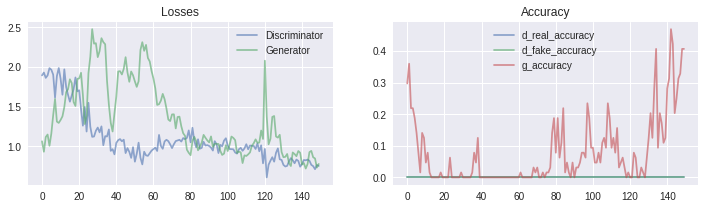

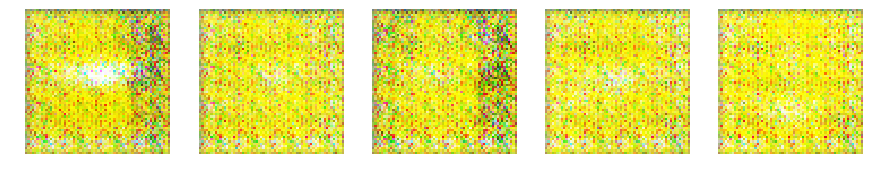

Epoch 2/50 
Duration: 107.01420 
D Loss: 0.80785 
G Loss: 0.90269


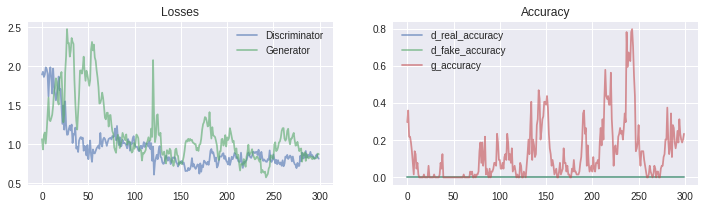

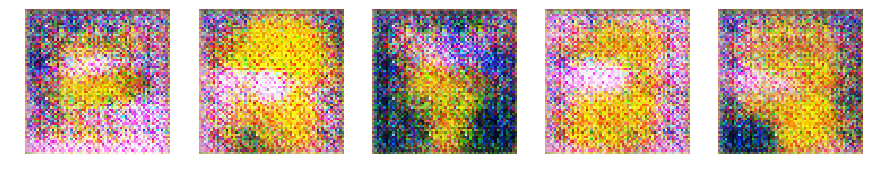

Epoch 3/50 
Duration: 106.95543 
D Loss: 0.80938 
G Loss: 0.78564


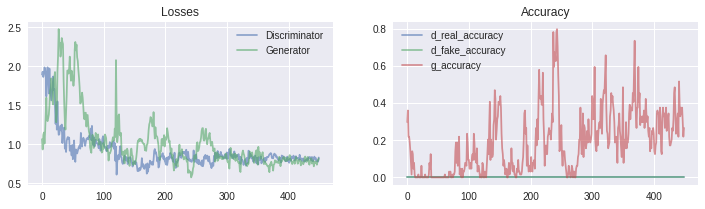

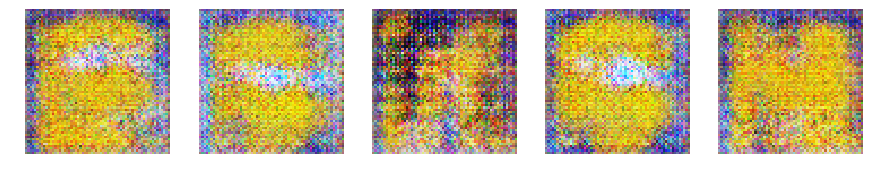

Epoch 4/50 
Duration: 106.97819 
D Loss: 0.77201 
G Loss: 0.78907


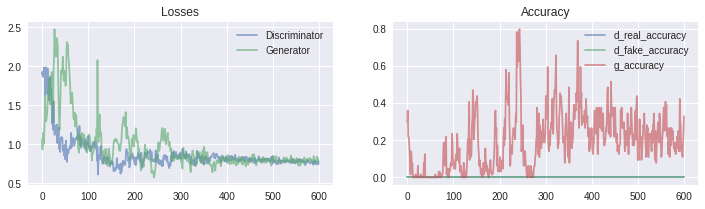

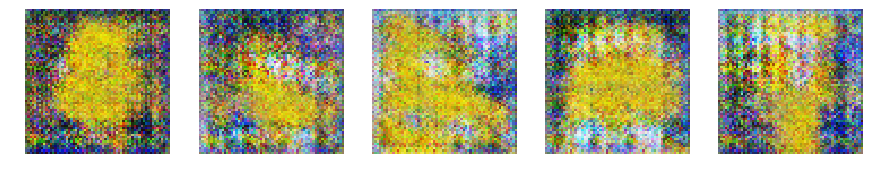

Epoch 5/50 
Duration: 106.97508 
D Loss: 0.75125 
G Loss: 0.80215


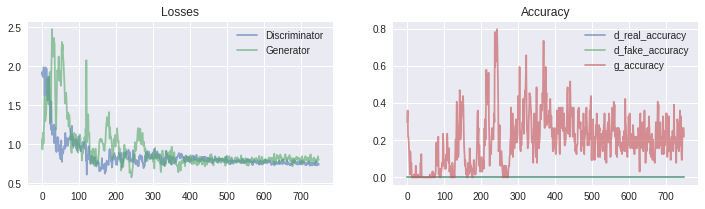

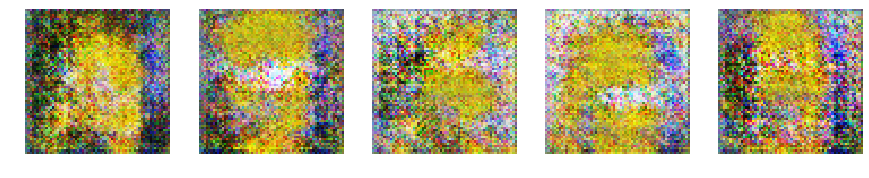

Epoch 6/50 
Duration: 106.84210 
D Loss: 0.74098 
G Loss: 0.81638


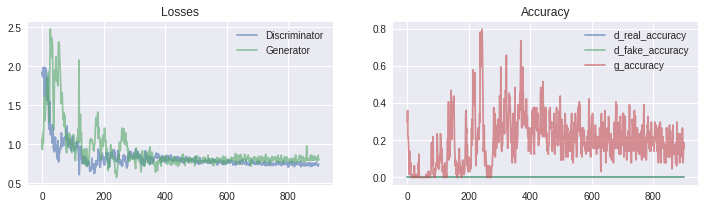

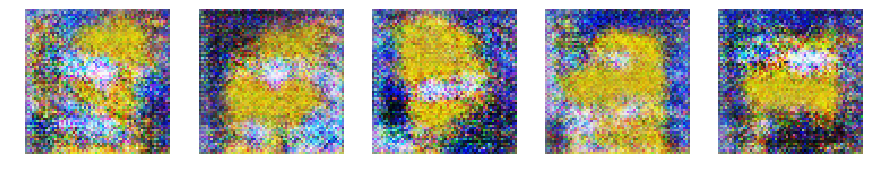

Epoch 7/50 
Duration: 107.07200 
D Loss: 0.73555 
G Loss: 0.81304


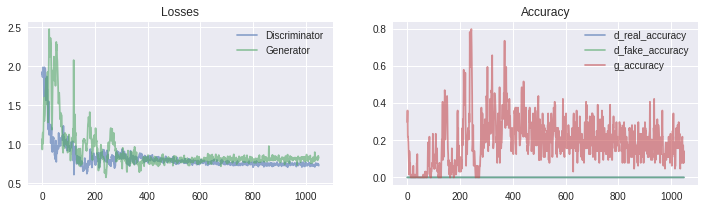

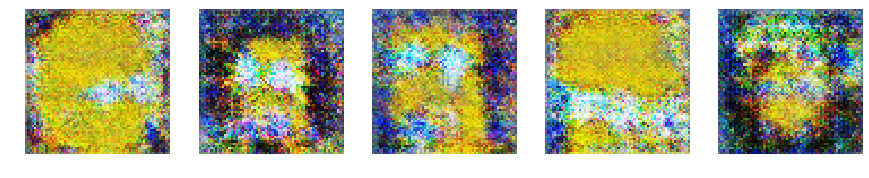

Epoch 8/50 
Duration: 107.11378 
D Loss: 0.72678 
G Loss: 0.80994


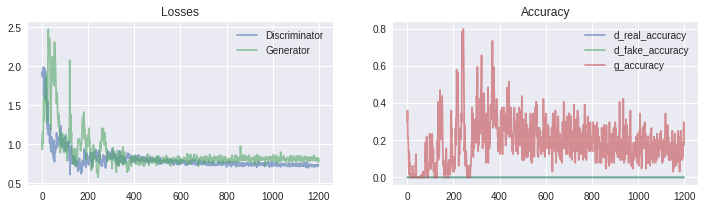

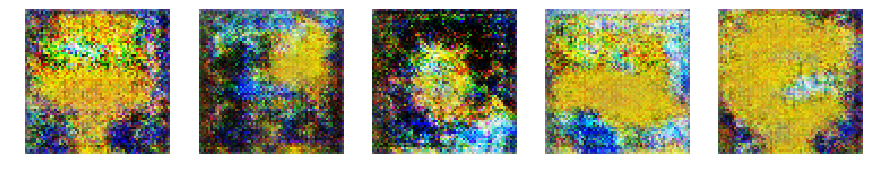

Epoch 9/50 
Duration: 107.25374 
D Loss: 0.72033 
G Loss: 0.81739


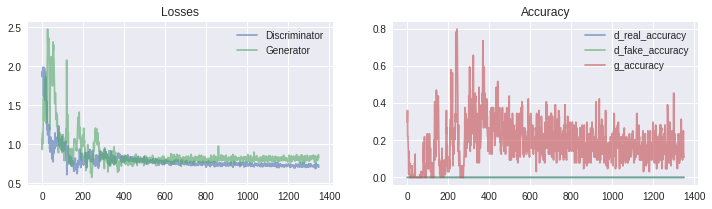

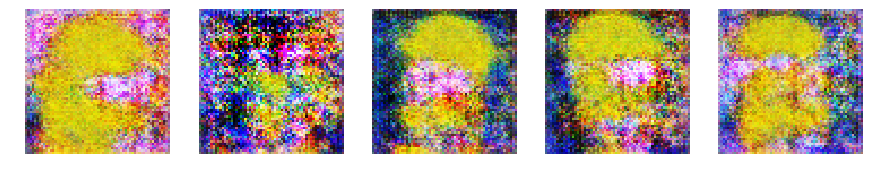

Epoch 10/50 
Duration: 107.03206 
D Loss: 0.71908 
G Loss: 0.82703


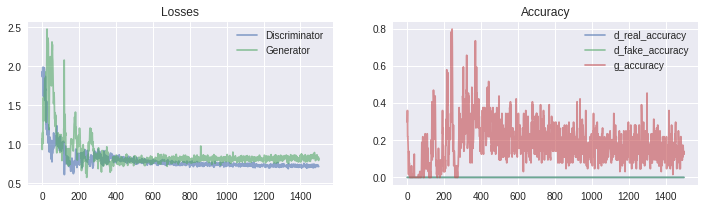

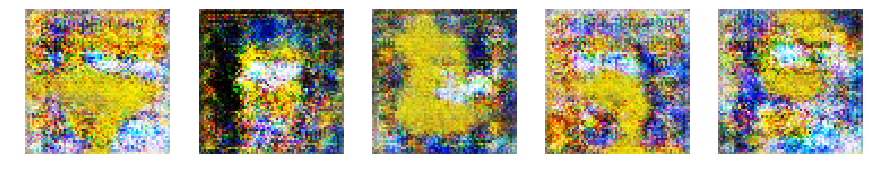

Epoch 11/50 
Duration: 107.02176 
D Loss: 0.71484 
G Loss: 0.82927


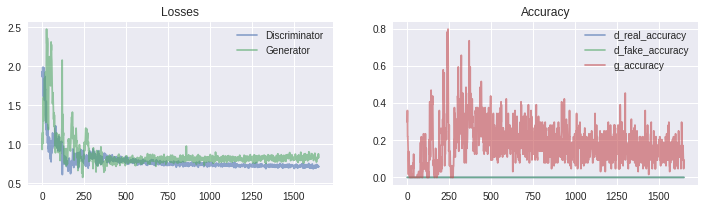

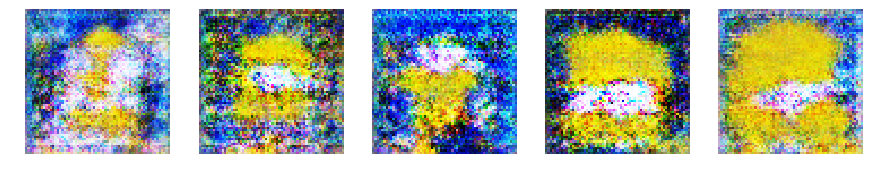

Epoch 12/50 
Duration: 106.76853 
D Loss: 0.70931 
G Loss: 0.82408


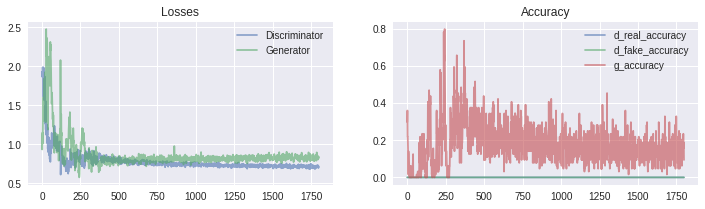

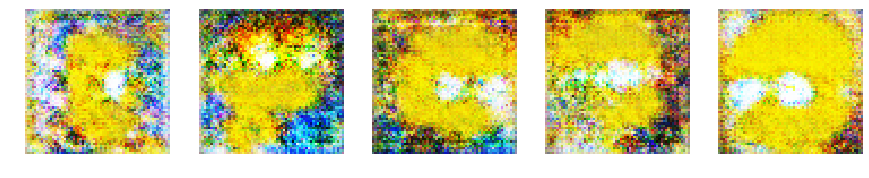

Epoch 13/50 
Duration: 106.54119 
D Loss: 0.70623 
G Loss: 0.83329


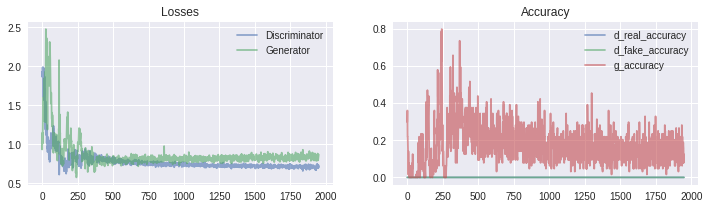

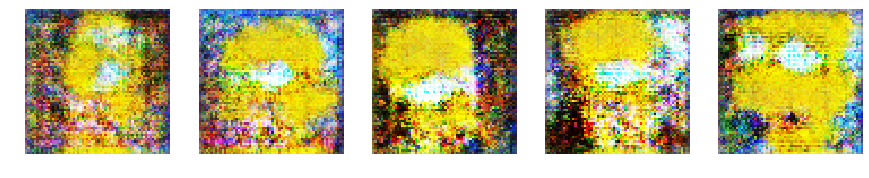

Epoch 14/50 
Duration: 106.69568 
D Loss: 0.70503 
G Loss: 0.83456


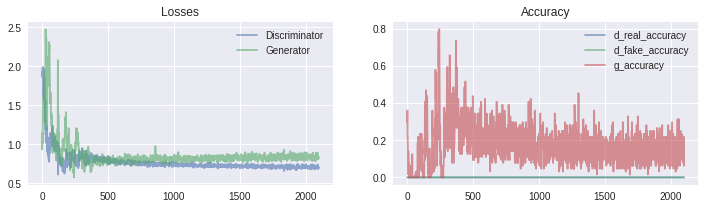

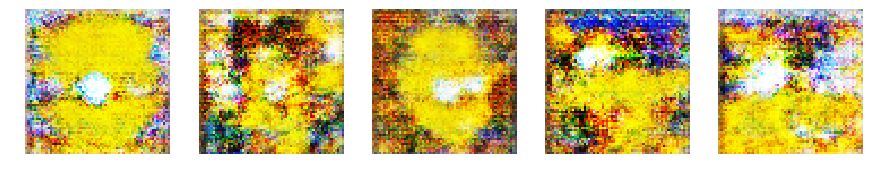

Epoch 15/50 
Duration: 106.63072 
D Loss: 0.70209 
G Loss: 0.83726


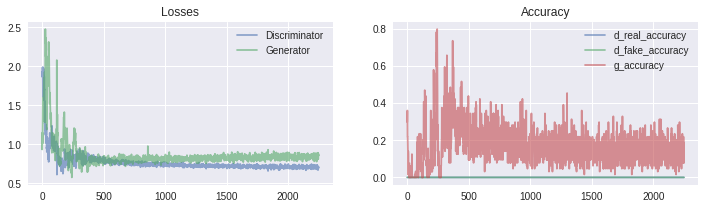

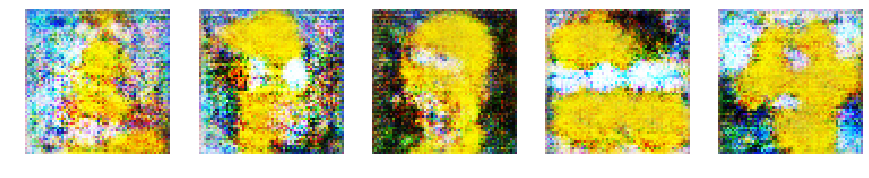

Epoch 16/50 
Duration: 106.72598 
D Loss: 0.69443 
G Loss: 0.83882


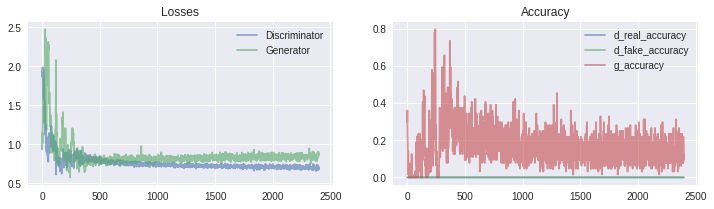

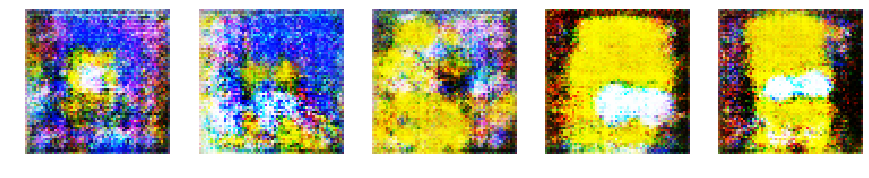

Epoch 17/50 
Duration: 106.74665 
D Loss: 0.69592 
G Loss: 0.84253


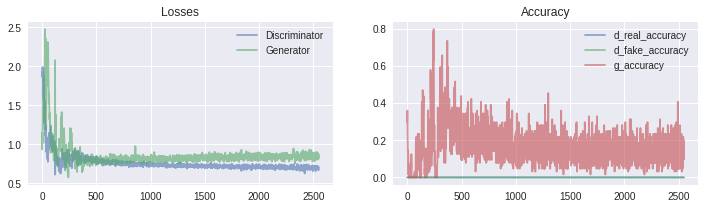

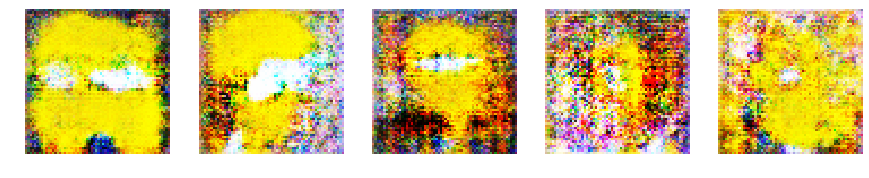

Epoch 18/50 
Duration: 106.44919 
D Loss: 0.69365 
G Loss: 0.85266


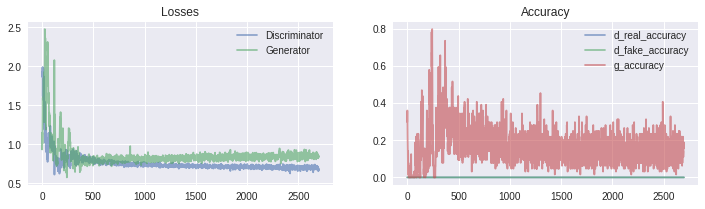

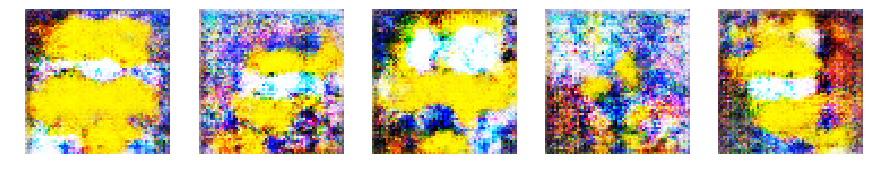

Epoch 19/50 
Duration: 106.68276 
D Loss: 0.69296 
G Loss: 0.85626


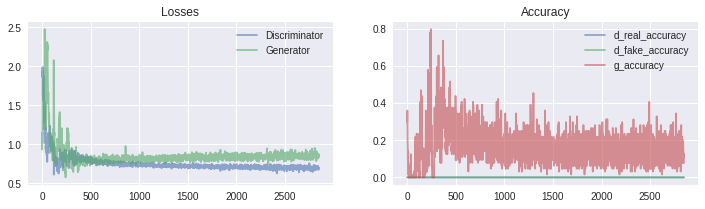

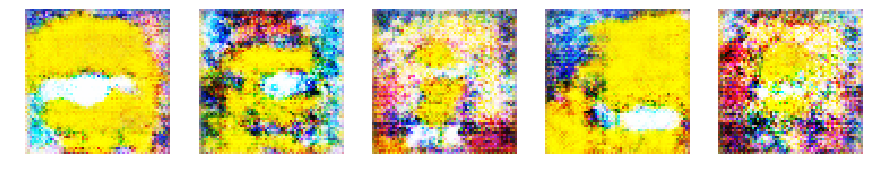

Epoch 20/50 
Duration: 106.83905 
D Loss: 0.69401 
G Loss: 0.85535


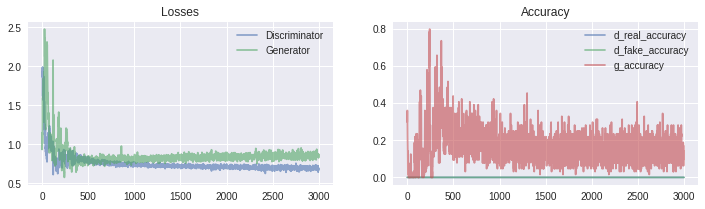

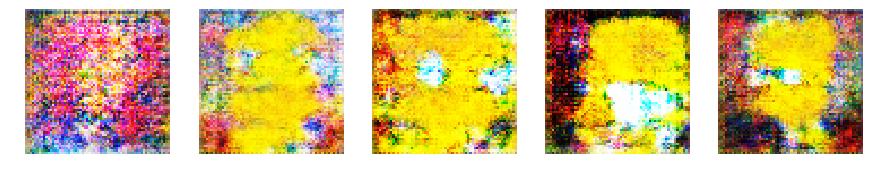

Epoch 21/50 
Duration: 106.62435 
D Loss: 0.68997 
G Loss: 0.85930


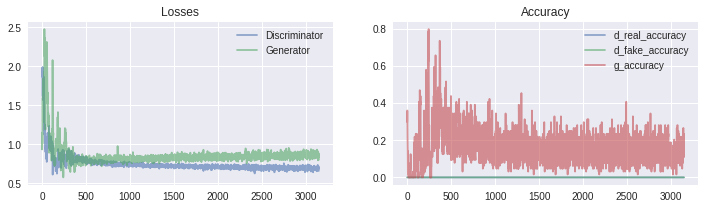

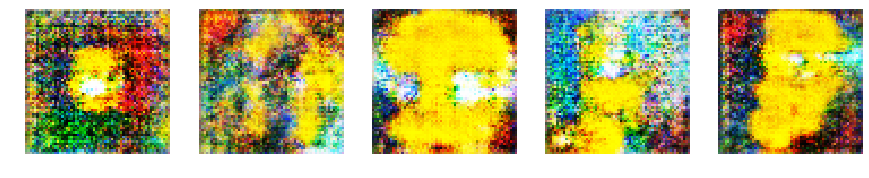

Epoch 22/50 
Duration: 106.81118 
D Loss: 0.68049 
G Loss: 0.84973


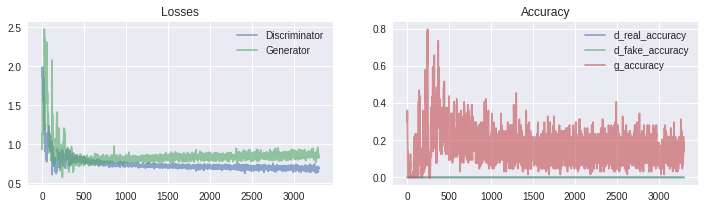

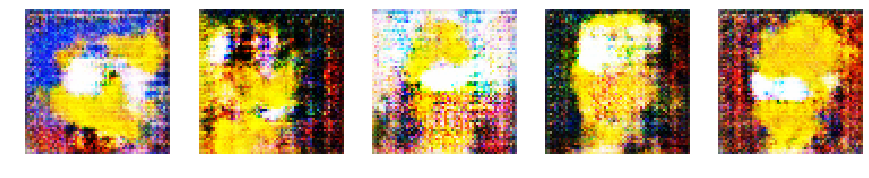

Epoch 23/50 
Duration: 106.63533 
D Loss: 0.68421 
G Loss: 0.86900


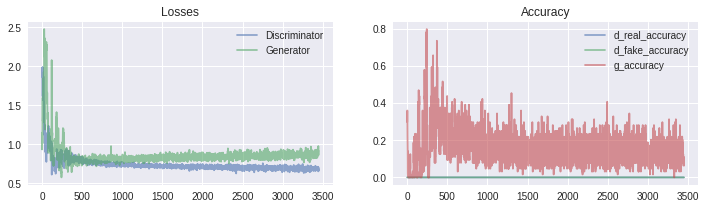

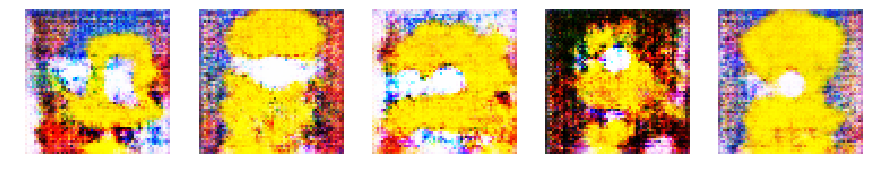

Epoch 24/50 
Duration: 106.55040 
D Loss: 0.67819 
G Loss: 0.87622


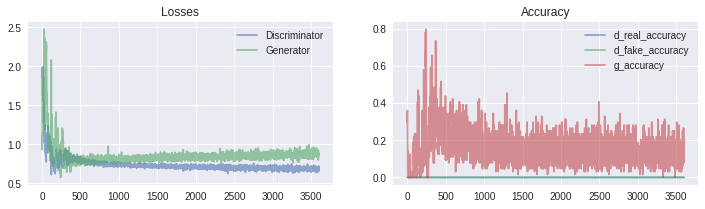

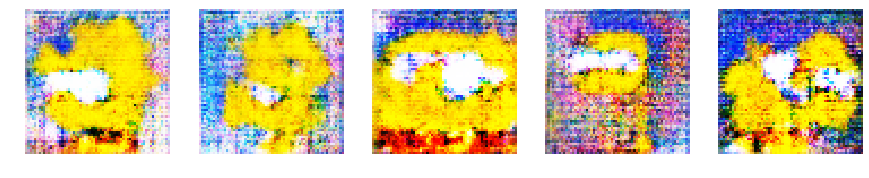

Epoch 25/50 
Duration: 106.60269 
D Loss: 0.68021 
G Loss: 0.87179


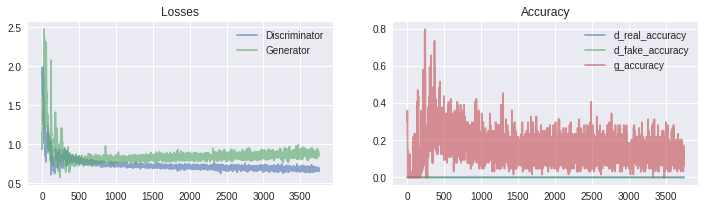

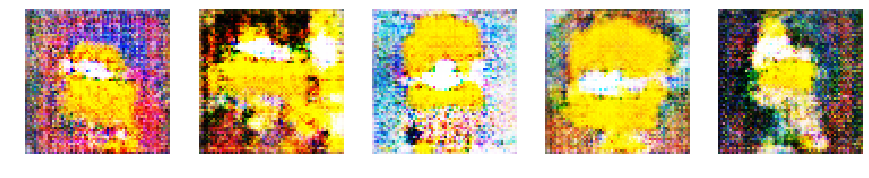

Epoch 26/50 
Duration: 107.02886 
D Loss: 0.66705 
G Loss: 0.88860


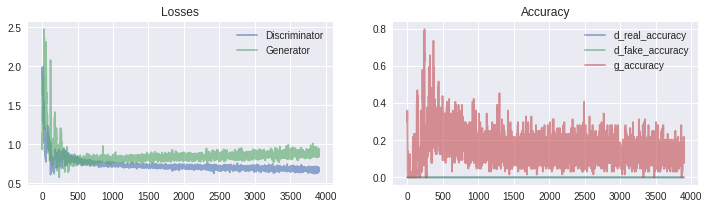

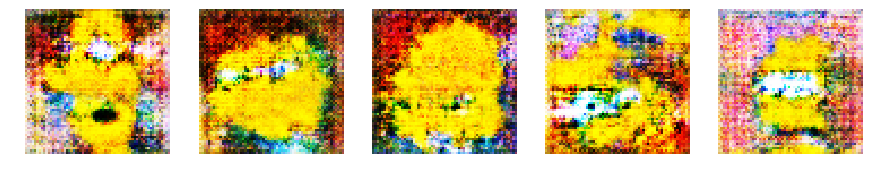

Epoch 27/50 
Duration: 106.59804 
D Loss: 0.66643 
G Loss: 0.90555


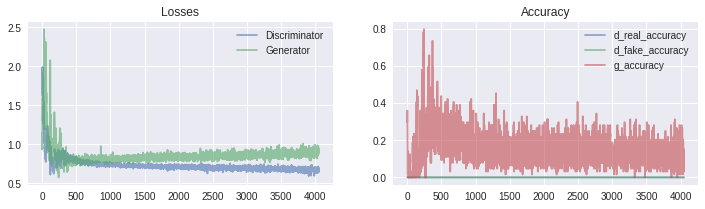

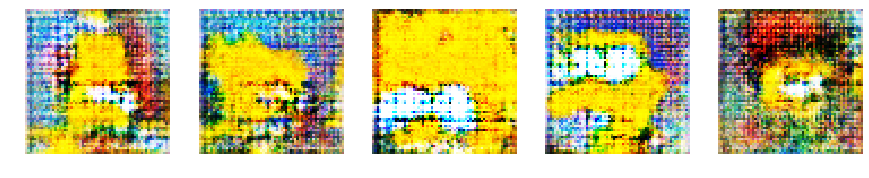

Epoch 28/50 
Duration: 106.69492 
D Loss: 0.65724 
G Loss: 0.88315


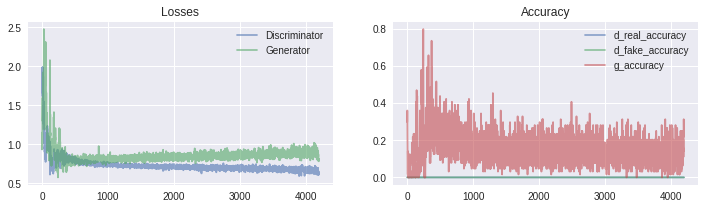

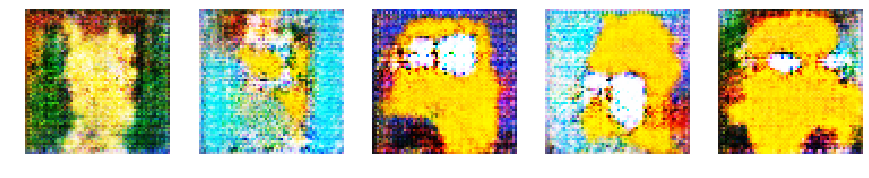

Epoch 29/50 
Duration: 106.64695 
D Loss: 0.66592 
G Loss: 0.90563


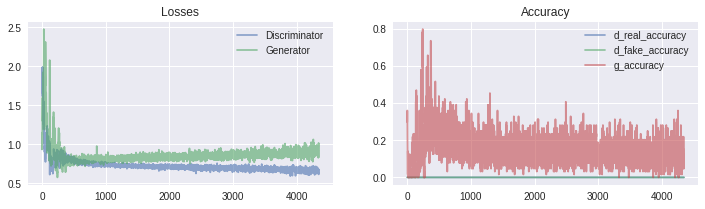

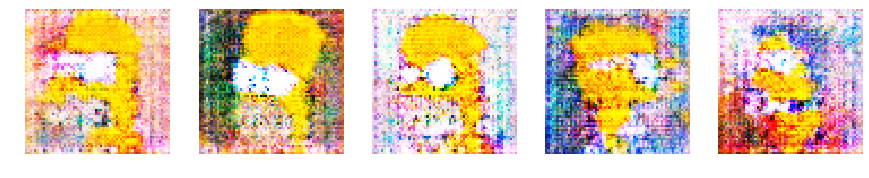

Epoch 30/50 
Duration: 106.63957 
D Loss: 0.64916 
G Loss: 0.90026


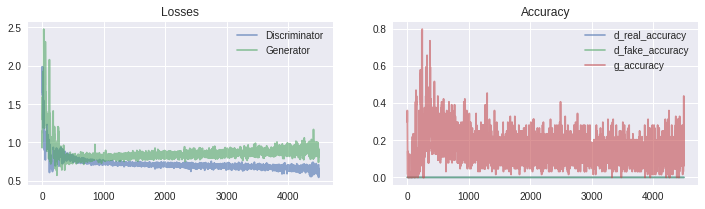

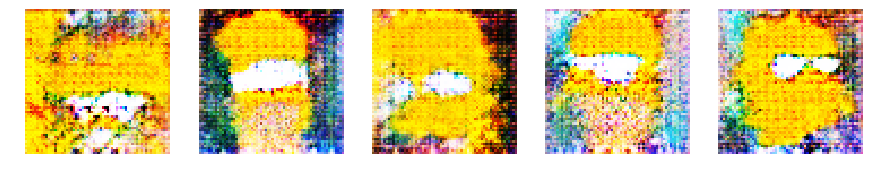

Epoch 31/50 
Duration: 106.66862 
D Loss: 0.64483 
G Loss: 0.94989


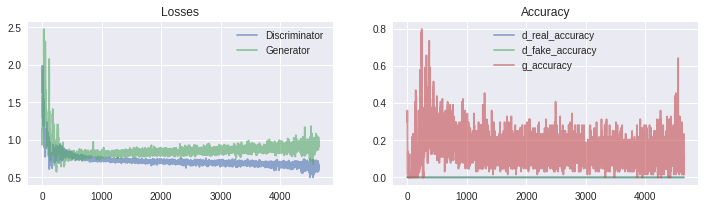

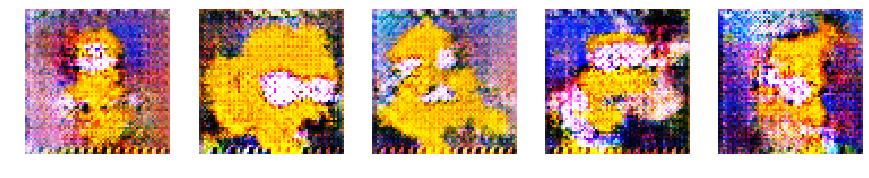

Epoch 32/50 
Duration: 106.65039 
D Loss: 0.63987 
G Loss: 0.96789


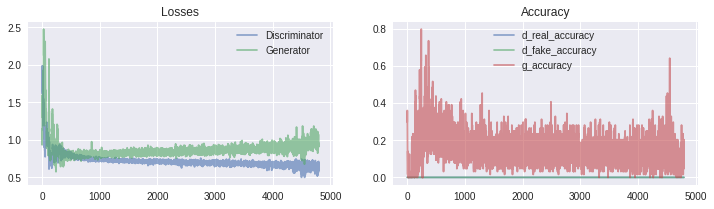

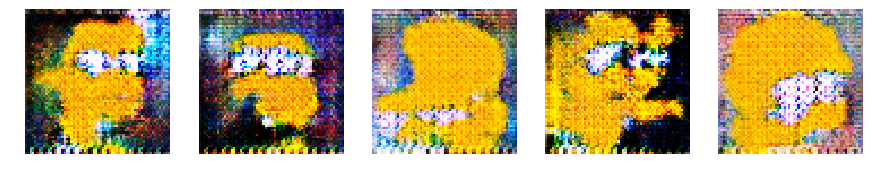

Epoch 33/50 
Duration: 106.48978 
D Loss: 0.63283 
G Loss: 0.97584


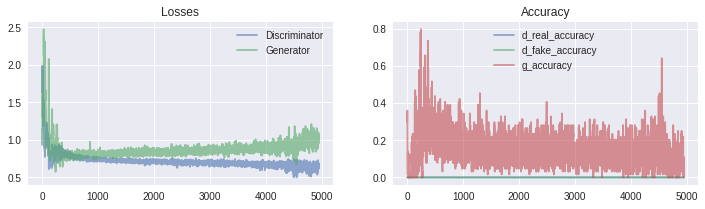

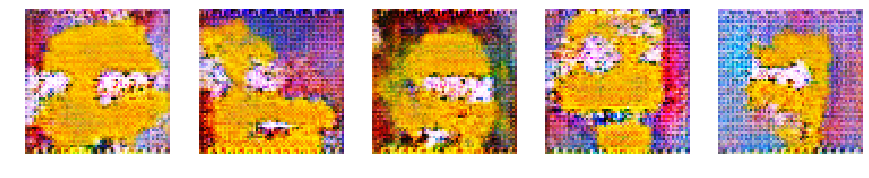

Epoch 34/50 
Duration: 106.74469 
D Loss: 0.62460 
G Loss: 1.00573


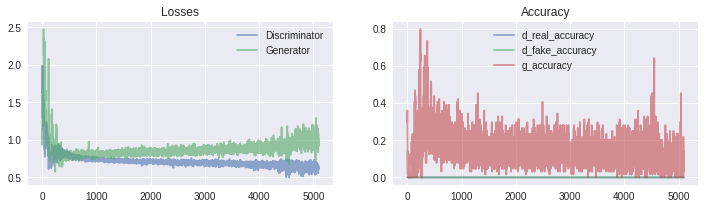

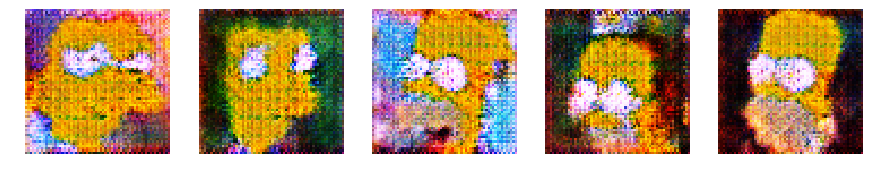

Epoch 35/50 
Duration: 106.61388 
D Loss: 0.63317 
G Loss: 1.00520


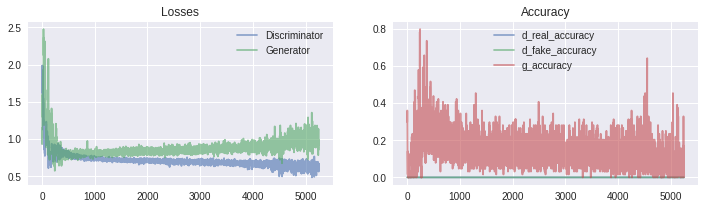

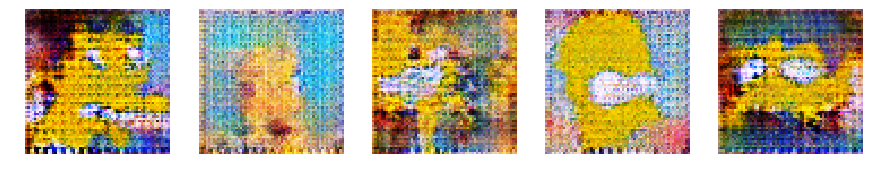

Epoch 36/50 
Duration: 106.46153 
D Loss: 0.62316 
G Loss: 1.01603


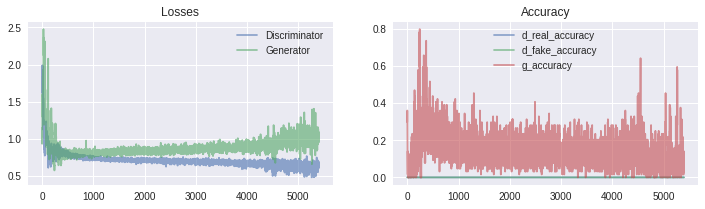

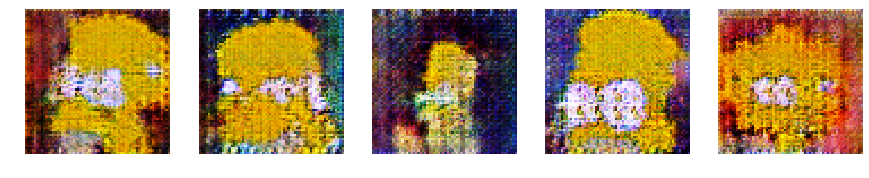

Epoch 37/50 
Duration: 106.80674 
D Loss: 0.63595 
G Loss: 0.94047


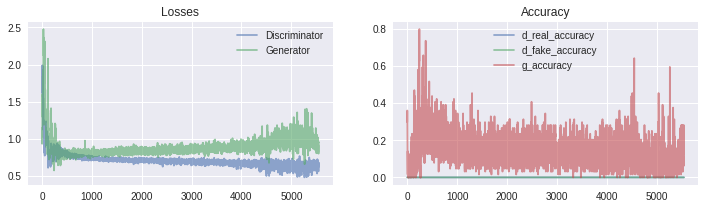

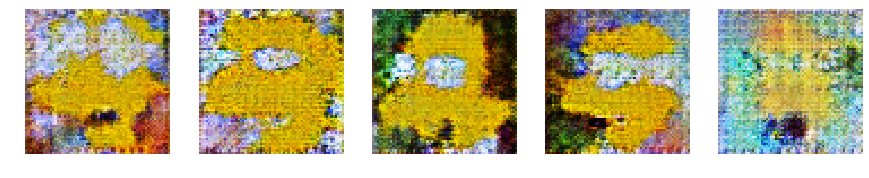

Epoch 38/50 
Duration: 106.88781 
D Loss: 0.64110 
G Loss: 0.95584


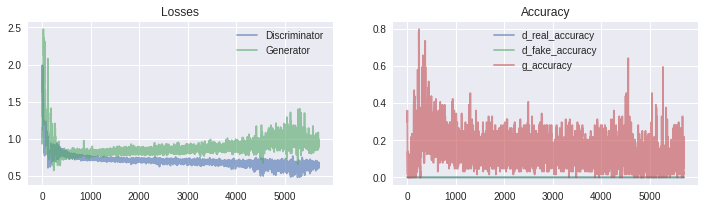

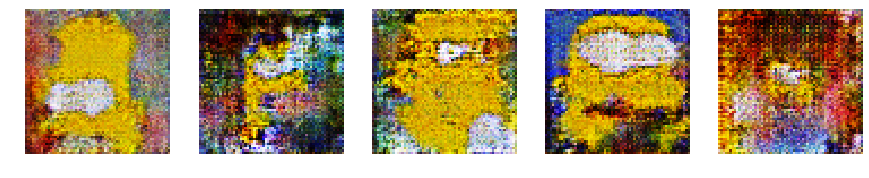

Epoch 39/50 
Duration: 106.71447 
D Loss: 0.63143 
G Loss: 0.94080


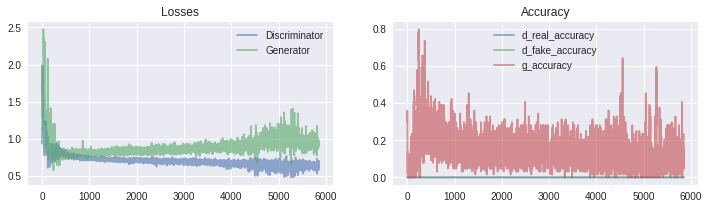

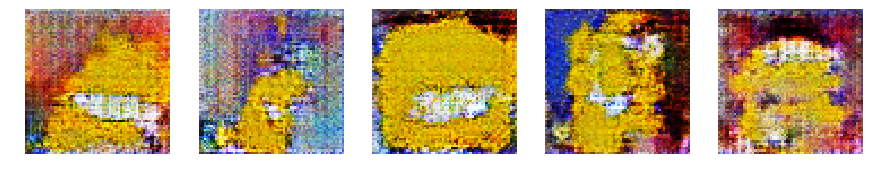

Epoch 40/50 
Duration: 106.94376 
D Loss: 0.63086 
G Loss: 0.94959


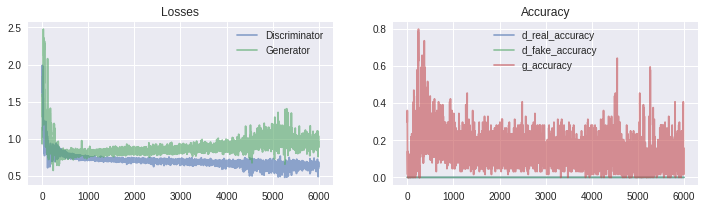

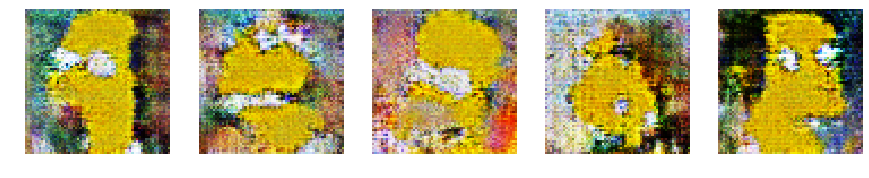

Epoch 41/50 
Duration: 106.74635 
D Loss: 0.61571 
G Loss: 0.94311


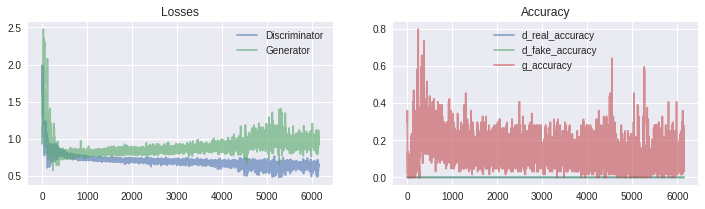

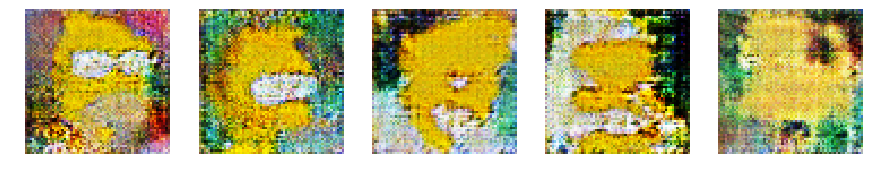

Epoch 42/50 
Duration: 106.71808 
D Loss: 0.61624 
G Loss: 0.98115


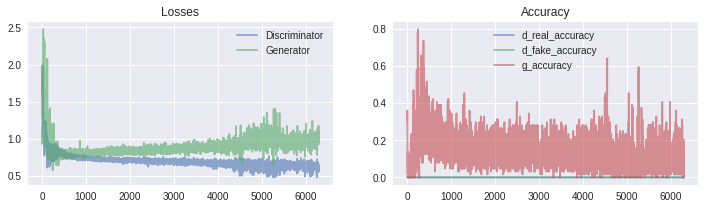

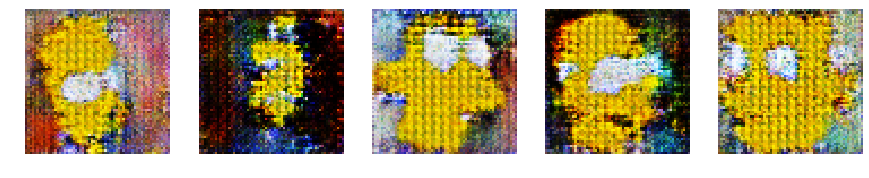

Epoch 43/50 
Duration: 107.06070 
D Loss: 0.62398 
G Loss: 0.97463


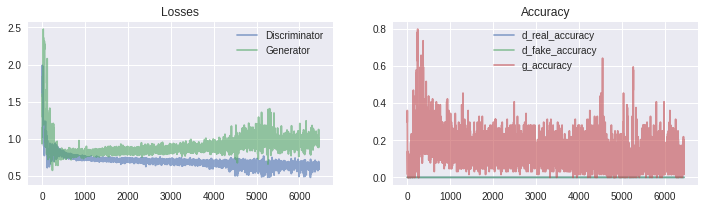

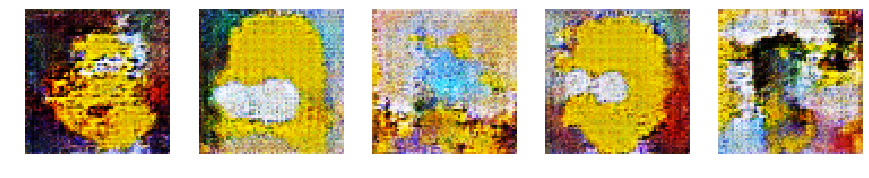

Epoch 44/50 
Duration: 107.18721 
D Loss: 0.61489 
G Loss: 1.00660


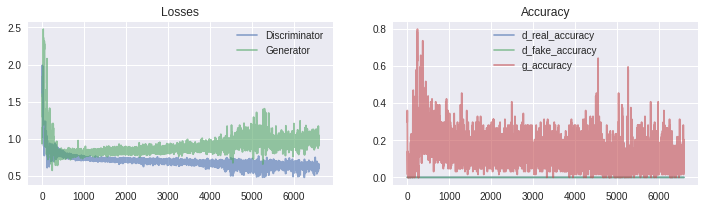

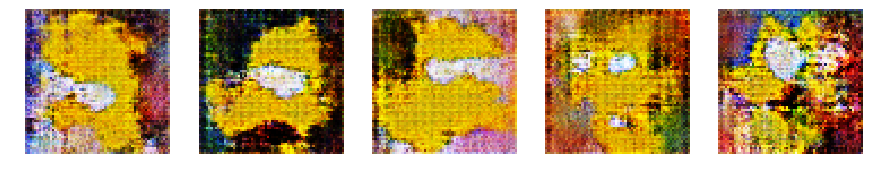

Epoch 45/50 
Duration: 106.70191 
D Loss: 0.59564 
G Loss: 0.98327


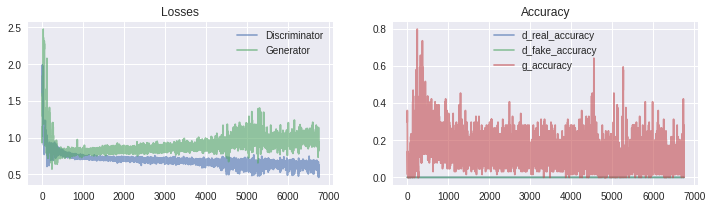

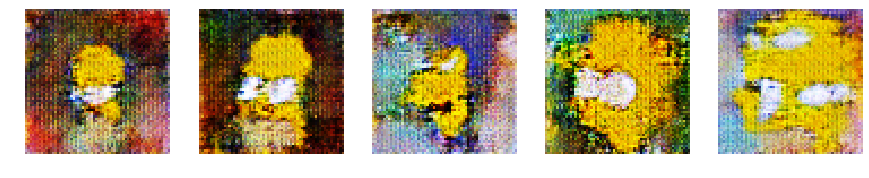

Epoch 46/50 
Duration: 107.08553 
D Loss: 0.61184 
G Loss: 1.02520


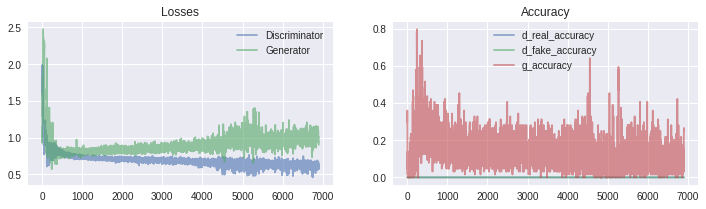

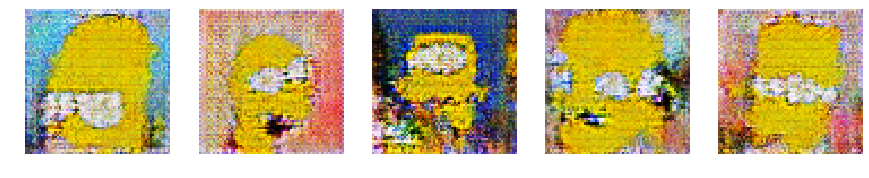

Epoch 47/50 
Duration: 106.56351 
D Loss: 0.60833 
G Loss: 1.03637


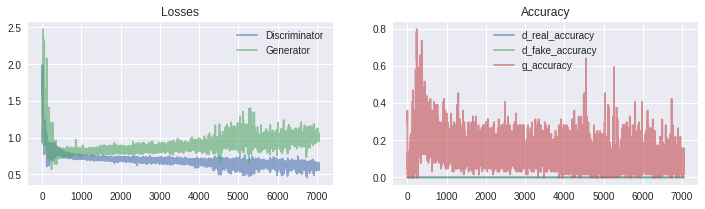

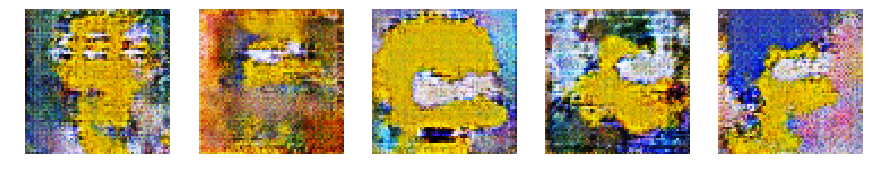

Epoch 48/50 
Duration: 106.71340 
D Loss: 0.59746 
G Loss: 1.03903


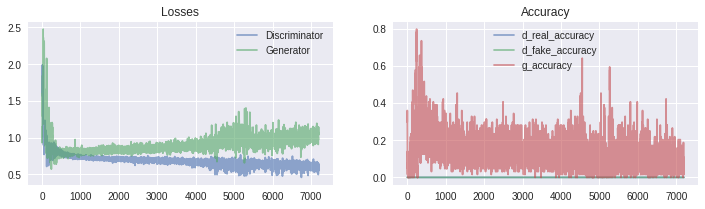

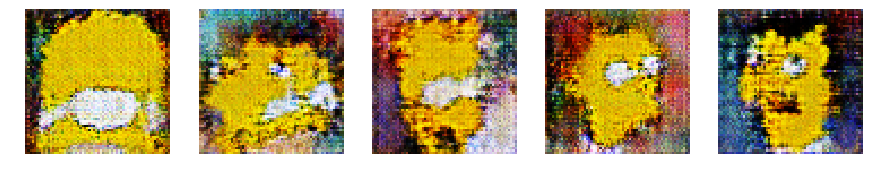

Epoch 49/50 
Duration: 106.65034 
D Loss: 0.59665 
G Loss: 1.04527


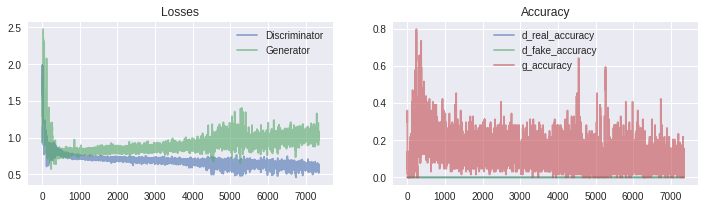

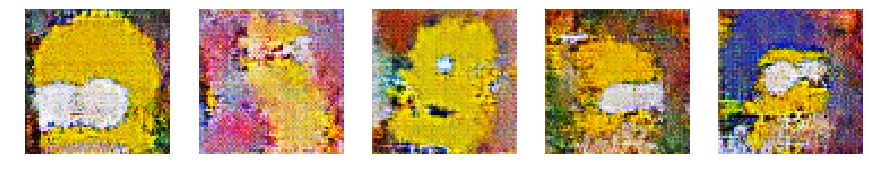

Epoch 50/50 
Duration: 106.63859 
D Loss: 0.59455 
G Loss: 1.05928


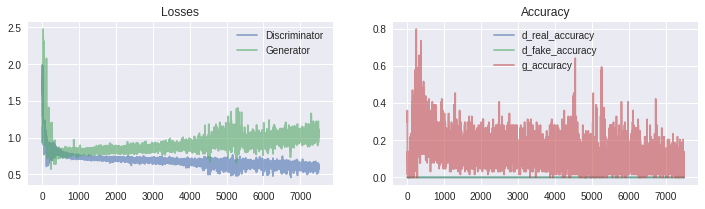

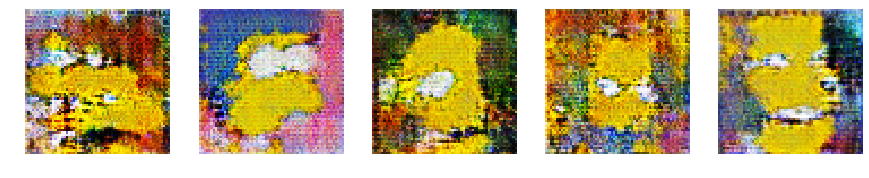

In [44]:
# train(get_batches(input_images[:300,:,:,:]), generator, discriminator, gan)
train(get_batches(input_images), generator, discriminator, gan)